In [44]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [45]:
from tqdm import tqdm

# 데이터 전처리

```

TurbID - 발전기 ID

Day - 날짜

Tmstamp - 시간

Wspd - 풍속

Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이

Etmp - 외부 온도

Itmp - 터빈 내부 온도

Ndir - 터빈이 바라보는 방향 각도

Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름

Prtv - 무효전력 : 에너지원을 필요로 하지 않는 전력

Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

````


베이스 라인 제공 전처리 방법

In [46]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [47]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [48]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


# 데이터셋

In [49]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 192): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Patv"]
            
            # feature 선택 및 제거
            train_tmp = train_tmp.drop(["Day"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y

def make_valid_data(data):
    valid_x, valid_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(194, 195): # validation 28일
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            valid_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Patv"]
            
            # feature 선택 및 제거
            valid_tmp = valid_tmp.drop(["Day"], axis = 1)
            
            valid_x.append(np.array(valid_tmp))
            valid_y.append(np.array(label_tmp))
            
    return valid_x, valid_y




In [62]:
# time stamp label encoding
tms_list = list(pd.unique(train_data["Tmstamp"]))

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x))

train_x, train_y = make_train_data(train_data)
valid_x, valid_y = make_valid_data(train_data)


100%|███████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 190.35it/s]


In [63]:
#train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_x = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_y = np.array(train_y)

In [64]:
#train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
valid_x = np.array(valid_x).reshape(-1, valid_x[0].shape[0], valid_x[0].shape[1])
valid_y = np.array(valid_y)

In [65]:
print(train_x.shape, train_y.shape)

(25594, 720, 12) (25594, 288)


In [66]:
print(valid_x.shape, valid_y.shape)

(134, 720, 12) (134, 288)


input dimension은 (Batch, Time_step, Feature dimension) 순이다. (batch_first=True)

output이 288인 이유는 2일이라서

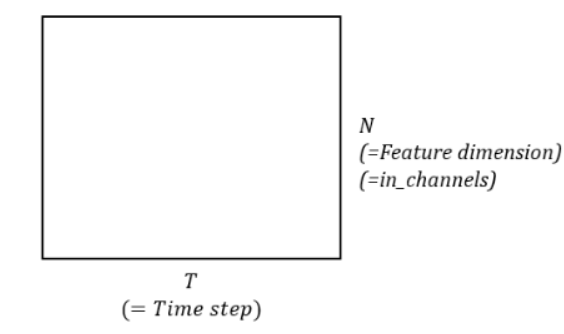

# 데이터 로더

In [77]:
EPOCHS = 10
BATCH_SIZE = 32
lr = 1e-3

In [68]:
from torch.utils.data import Dataset, DataLoader

class TimeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        
        return torch.Tensor(self.X[index]) # 테스트셋 용
    


In [69]:
train_dataset = TimeDataset(train_x, train_y)
valid_dataset = TimeDataset(valid_x, valid_y)


train_loader = DataLoader(train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(valid_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)



# 데이터 확인

In [70]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0].shape)


X_train :  torch.Size([32, 720, 12]) type: torch.FloatTensor
Y_train :  torch.Size([32, 288]) type: torch.FloatTensor
torch.Size([288])


In [71]:
#valiation set 확인
for (X_valid,Y_valid) in valid_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0].shape)

X_valid :  torch.Size([32, 720, 12]) type: torch.FloatTensor
Y_valid :  torch.Size([32, 288]) type: torch.FloatTensor
torch.Size([288])


# 모델


### input 설명

- input_size: input의 feature dimension을 넣어주어야 한다. time step이 아니라 feature dimension!
- hidden_size: 내부에서 어떤 feature dimension으로 바꿔주고 싶은지를 넣어주면 된다.
- num_layers: lstm layer를 얼마나 쌓을지
- bias: bias term을 둘 것인가 (Default: True)
- batch_first: batch가 0번 dimension으로 오게 하려면 이거 설정! 난 이거 설정 가정하고 설명했다. (Default: False)
- dropout: 가지치기 얼마나 할지, generalization 잘안되면 이걸 조정하면 된다.
bidirectional: 양방향으로 할지 말지 (bidirectional 하면 [forward, backword] 로 feature dimension 2배 됨)



참고.

https://sanghyu.tistory.com/52

### output 설명

- outputs는 (output, (hidden or hidden stat,cell stat)) 의 tuple 형태로 나오므로 주의해서 써야한다. (LSTM만 cell state있음)
- output: output dimension은 (batch, time_step, hidden dimension) 순이다. 양방향일 경우 hidden_size*2
- hidden state: 모든 layer의 hidden state를 담고있다.
- cell state: 모든 layer의 cell state를 담고있다.

In [72]:
gru = nn.GRU(input_size=11, hidden_size=256, batch_first=True, bidirectional=False)

gru(X_valid)[0].size()

RuntimeError: input.size(-1) must be equal to input_size. Expected 11, got 12

In [18]:
X_train[:,:,:].size()

torch.Size([32, 720, 12])

In [19]:
X_train[:,-1,-1].unsqueeze(1).size()

torch.Size([32, 1])

In [20]:
X_train[:,:,0]

tensor([[131., 131., 131.,  ..., 131., 131., 131.],
        [ 32.,  32.,  32.,  ...,  32.,  32.,  32.],
        [115., 115., 115.,  ..., 115., 115., 115.],
        ...,
        [112., 112., 112.,  ..., 112., 112., 112.],
        [107., 107., 107.,  ..., 107., 107., 107.],
        [ 14.,  14.,  14.,  ...,  14.,  14.,  14.]])

In [21]:
X_train[:,:,0].size()

torch.Size([32, 720])

In [22]:
X_train[:,:, : -1]

tensor([[[ 1.3100e+02,  0.0000e+00,  1.7100e+00,  ...,  2.9300e+00,
           2.9300e+00, -1.0000e-01],
         [ 1.3100e+02,  1.0000e+00,  2.2300e+00,  ...,  4.7680e+01,
           4.7670e+01, -3.0000e-01],
         [ 1.3100e+02,  2.0000e+00,  3.0300e+00,  ...,  2.5910e+01,
           2.5910e+01,  4.5900e+00],
         ...,
         [ 1.3100e+02,  1.4100e+02,  1.2030e+01,  ...,  6.1300e+00,
           6.1300e+00,  1.5248e+02],
         [ 1.3100e+02,  1.4200e+02,  1.1750e+01,  ...,  5.0700e+00,
           5.0700e+00,  1.7088e+02],
         [ 1.3100e+02,  1.4300e+02,  1.1860e+01,  ...,  4.6800e+00,
           4.6700e+00,  1.7310e+02]],

        [[ 3.2000e+01,  0.0000e+00,  7.6400e+00,  ...,  2.3000e+00,
           2.3000e+00,  2.5270e+01],
         [ 3.2000e+01,  1.0000e+00,  7.7000e+00,  ...,  2.4000e+00,
           2.4000e+00, -1.3934e+02],
         [ 3.2000e+01,  2.0000e+00,  7.8100e+00,  ...,  4.1800e+00,
           4.1800e+00, -7.2570e+01],
         ...,
         [ 3.2000e+01,  1

In [23]:
gru(X_valid)[0][:,-1,:].size()

torch.Size([32, 256])

In [73]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.gru = nn.GRU(input_size=11, hidden_size=256, batch_first=True, bidirectional=False)
        self.classifier = nn.Sequential(
            nn.Linear(256+1,516),# 사이즈는 hidden size에 따라 결정.
            nn.ReLU(),
            nn.Linear(516,288), #결과 288개 예측.
            nn.ReLU(),  
        )
        
    def forward(self, x):
        turbin_id=x[:,-1,0].unsqueeze(1)
        x=x[:,:,:-1]
        hidden, _ = self.gru(x)
        hidden = hidden[:,-1,:]
        hidden=torch.cat([hidden,turbin_id],axis=1)
        output = self.classifier(hidden) # -1은 hidden state의 마지막 time step값을 가져온 것.
        return output

In [74]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0
    train_mae_loss = 0
    for batch_idx,(X, Y) in enumerate(train_loader):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        optimizer.zero_grad()#데이터들 장비에 할당
        output = model(X) # model로 output을 계산
        loss = criterion(output, Y)
        
        train_loss += loss.item()
        
        with torch.no_grad():
            mae = metric(output, Y)
            train_mae_loss+=mae.item()
        loss.backward()
        optimizer.step()
    
    train_loss/=len(train_loader.dataset)
    train_mae_loss/=len(train_loader.dataset)
    
    return train_loss,train_mae_loss



In [75]:
#8. 학습
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    valid_mae = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for X, Y in valid_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            output = model(X) # model로 output을 계산
            
            loss = criterion(output, Y)
            valid_loss += loss.item()
            mae = metric(output, Y)
            valid_mae+=mae.item()
    valid_loss/=len(valid_loader.dataset)
    valid_mae/=len(valid_loader.dataset)
    
    return valid_loss, valid_mae


In [78]:
#학습 진행 코드


check_path = './checkpoint/checkpoint_baseline.pt'
print(check_path)
model = BaseModel().to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
metric = nn.L1Loss().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

best_valid_mae = 999999
best_valid_loss = 9999999999

for Epoch in range(1,EPOCHS+1):
    train_loss,train_mae = train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_mae = evaluate(model, valid_loader)
    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train MAE:{:.4f}  | \tValid Loss:{:.4f} \tValid MAE: {:.4f}\n".
                  format(Epoch, train_loss, train_mae, valid_loss, valid_mae))
    if best_valid_loss > valid_loss:
        print("-- SAVE Checkpoint --")
        print("Valid loss : {:.4f} -> {:.4f} \n".format(best_valid_loss,valid_loss))
        torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
        best_valid_mae = valid_mae
        best_valid_loss = valid_loss
        
    
    

./checkpoint/checkpoint_baseline.pt

[EPOCH:1]	 Train Loss:18050.2615	 Train MAE:11.0844  | 	Valid Loss:30848.6119 	Valid MAE: 19.2724

-- SAVE Checkpoint --
Valid loss : 9999999999.0000 -> 30848.6119 


[EPOCH:2]	 Train Loss:17928.7659	 Train MAE:11.0810  | 	Valid Loss:30089.1535 	Valid MAE: 18.8396

-- SAVE Checkpoint --
Valid loss : 30848.6119 -> 30089.1535 


[EPOCH:3]	 Train Loss:17827.3606	 Train MAE:11.0790  | 	Valid Loss:30650.0882 	Valid MAE: 18.9454


[EPOCH:4]	 Train Loss:17723.1620	 Train MAE:11.0773  | 	Valid Loss:30523.2771 	Valid MAE: 19.0598


[EPOCH:5]	 Train Loss:17620.6542	 Train MAE:11.0747  | 	Valid Loss:30681.3382 	Valid MAE: 19.1358


[EPOCH:6]	 Train Loss:17541.5083	 Train MAE:11.0739  | 	Valid Loss:30113.7290 	Valid MAE: 18.9730


[EPOCH:7]	 Train Loss:17451.3923	 Train MAE:11.0707  | 	Valid Loss:29459.9776 	Valid MAE: 18.5980

-- SAVE Checkpoint --
Valid loss : 30089.1535 -> 29459.9776 


[EPOCH:8]	 Train Loss:17387.0051	 Train MAE:11.0685  | 	Valid Loss:29937

# validation 확인

In [79]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 29459.9776 / Valid MAE : 18.5980 



# TEST

In [80]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(196, 201)]

test_data = train_data[train_data["Day"].isin(test_data_list)]

test_data = test_data.drop(["Day"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#train set 처럼 batch,720,11로 고치기


In [81]:
test_data.shape

(134, 720, 12)

In [82]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [40]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            
            pred = model(X)
            preds += pred.cpu().tolist()
    
    return np.array(preds)

In [41]:
model = BaseModel().to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_baseline.pt')
model.load_state_dict(best_checkpoint)
model.eval()

BaseModel(
  (gru): GRU(11, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=257, out_features=516, bias=True)
    (1): ReLU()
    (2): Linear(in_features=516, out_features=288, bias=True)
    (3): ReLU()
  )
)

In [83]:
preds = predict(model, test_loader)
preds = preds.reshape(-1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 84.86it/s]


In [85]:
sample_submission["Patv"] = preds
sample_submission.to_csv("./submit.csv", index = False)